In [1]:
import polars as pl 
import numpy as np

In [2]:
output_path = "../../1_snakemake/outputs"

In [38]:
def common_elements_in_lists(*lists):
    if not lists:
        return []
    
    intersection_set = set(lists[0])
    for lst in lists[1:]:
        intersection_set.intersection_update(lst)
    return list(intersection_set)


def print_pod_stats(feat_type: str, pod_type: str):

    if pod_type == "pod":
        pods = pl.read_parquet(f"{output_path}/{feat_type}/mad_featselect/curves/pods.parquet").select(
        ["Metadata_Compound", "bmd"]
        )

        pods_int = pl.read_parquet(f"{output_path}/{feat_type}/mad_int_featselect/curves/pods.parquet").select(
            ["Metadata_Compound", "bmd"]
        ).rename({"bmd": "bmd_int"})

        pods_log10 = pl.read_parquet(f"{output_path}/{feat_type}/mad_featselect_log10/curves/pods.parquet").select(
            ["Metadata_Compound", "bmd"]
        ).rename({"bmd": "bmd_log10"})

        pods_ap = pl.read_parquet(f"{output_path}/{feat_type}/mad_featselect_ap/curves/pods.parquet").select(
            ["Metadata_Compound", "bmd"]
        ).rename({"bmd": "bmd_ap"})
    elif pod_type == "bmd":
        pods = pl.read_parquet(f"{output_path}/{feat_type}/mad_featselect/curves/bmds.parquet").filter(
            (pl.col("gene.id") == "gmd") &
            (pl.col("all.pass") == True) &
            (pl.col("SDres") < 3*pl.col("SDctrl"))
        ).select(["Metadata_Compound", "bmd"])

        pods_int = pl.read_parquet(f"{output_path}/{feat_type}/mad_int_featselect/curves/bmds.parquet").filter(
            (pl.col("gene.id") == "gmd") &
            (pl.col("all.pass") == True) &
            (pl.col("SDres") < 3*pl.col("SDctrl"))
        ).select(
            ["Metadata_Compound", "bmd"]
        ).rename({"bmd": "bmd_int"})

        pods_log10 = pl.read_parquet(f"{output_path}/{feat_type}/mad_featselect_log10/curves/bmds.parquet").filter(
            (pl.col("gene.id") == "gmd") &
            (pl.col("all.pass") == True) &
            (pl.col("SDres") < 3*pl.col("SDctrl"))
        ).select(
            ["Metadata_Compound", "bmd"]
        ).rename({"bmd": "bmd_log10"})

        pods_ap = pl.read_parquet(f"{output_path}/{feat_type}/mad_featselect_ap/curves/bmds.parquet").filter(
            (pl.col("all.pass") == True) &
            (pl.col("SDres") < 3*pl.col("SDctrl"))
        ).select(
            ["Metadata_Compound", "bmd"]
        ).rename({"bmd": "bmd_ap"})

    # Get overlapping compounds
    cmpds = pods.select("Metadata_Compound").to_series().to_list()
    cmpds_int = pods_int.select("Metadata_Compound").to_series().to_list()
    cmpds_log10 = pods_log10.select("Metadata_Compound").to_series().to_list()
    cmpds_ap = pods_ap.select("Metadata_Compound").to_series().to_list()

    common_cmpds = common_elements_in_lists(cmpds, cmpds_int, cmpds_log10, cmpds_ap)
    print(len(common_cmpds))

    print(f"{feat_type} num PODs: {pods.shape[0]}")
    print(f"{feat_type}_int num PODs: {pods_int.shape[0]}")
    print(f"{feat_type}_log10 num PODs: {pods_log10.shape[0]}")
    print(f"{feat_type}_ap num PODs: {pods_ap.shape[0]}")

    print(f"{feat_type} median POD: {np.round(pods.filter(pl.col('Metadata_Compound').is_in(common_cmpds)).select('bmd').median().item(), 2)}")
    print(f"{feat_type}_int median POD: {np.round(pods_int.filter(pl.col('Metadata_Compound').is_in(common_cmpds)).select('bmd_int').median().item(), 2)}")
    print(f"{feat_type}_log10 median POD: {np.round(pods_log10.filter(pl.col('Metadata_Compound').is_in(common_cmpds)).select('bmd_log10').median().item(), 2)}")
    print(f"{feat_type}_ap median POD: {np.round(pods_ap.filter(pl.col('Metadata_Compound').is_in(common_cmpds)).select('bmd_ap').median().item(), 2)}")

    # combine all together
    all_pods = pods.join(pods_int, on="Metadata_Compound", how="full").with_columns(
        pl.coalesce(["Metadata_Compound", "Metadata_Compound_right"]).alias("Metadata_Compound")
    ).drop("Metadata_Compound_right")
    all_pods = all_pods.join(pods_log10, on="Metadata_Compound", how="full").with_columns(
        pl.coalesce(["Metadata_Compound", "Metadata_Compound_right"]).alias("Metadata_Compound")
    ).drop("Metadata_Compound_right")
    all_pods = all_pods.join(pods_ap, on="Metadata_Compound", how="full").with_columns(
        pl.coalesce(["Metadata_Compound", "Metadata_Compound_right"]).alias("Metadata_Compound")
    ).drop("Metadata_Compound_right")
    return(all_pods)

In [39]:
cellprofiler_gmd = print_pod_stats("cellprofiler", "bmd")

cellprofiler_gmd = cellprofiler_gmd.with_columns(
    pl.lit("cellprofiler").alias("Feature")
)

257
cellprofiler num PODs: 372
cellprofiler_int num PODs: 371
cellprofiler_log10 num PODs: 437
cellprofiler_ap num PODs: 431
cellprofiler median POD: 3.15
cellprofiler_int median POD: 3.15
cellprofiler_log10 median POD: 3.28
cellprofiler_ap median POD: 2.87


In [40]:
dino_gmd = print_pod_stats("dino", "bmd")

dino_gmd = dino_gmd.with_columns(
    pl.lit("dino").alias("Feature")
)

412
dino num PODs: 546
dino_int num PODs: 545
dino_log10 num PODs: 545
dino_ap num PODs: 480
dino median POD: 2.96
dino_int median POD: 2.96
dino_log10 median POD: 2.89
dino_ap median POD: 2.85


In [41]:
cpcnn_gmd = print_pod_stats("cpcnn", "bmd")

cpcnn_gmd = cpcnn_gmd.with_columns(
    pl.lit("cpcnn").alias("Feature")
)

365
cpcnn num PODs: 538
cpcnn_int num PODs: 535
cpcnn_log10 num PODs: 519
cpcnn_ap num PODs: 448
cpcnn median POD: 3.08
cpcnn_int median POD: 3.08
cpcnn_log10 median POD: 2.93
cpcnn_ap median POD: 2.94


## CellProfiler plots

/dgx1nas1/storage/data/jess/miniforge3/envs/axiom/lib/python3.9/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 193 rows containing missing values.


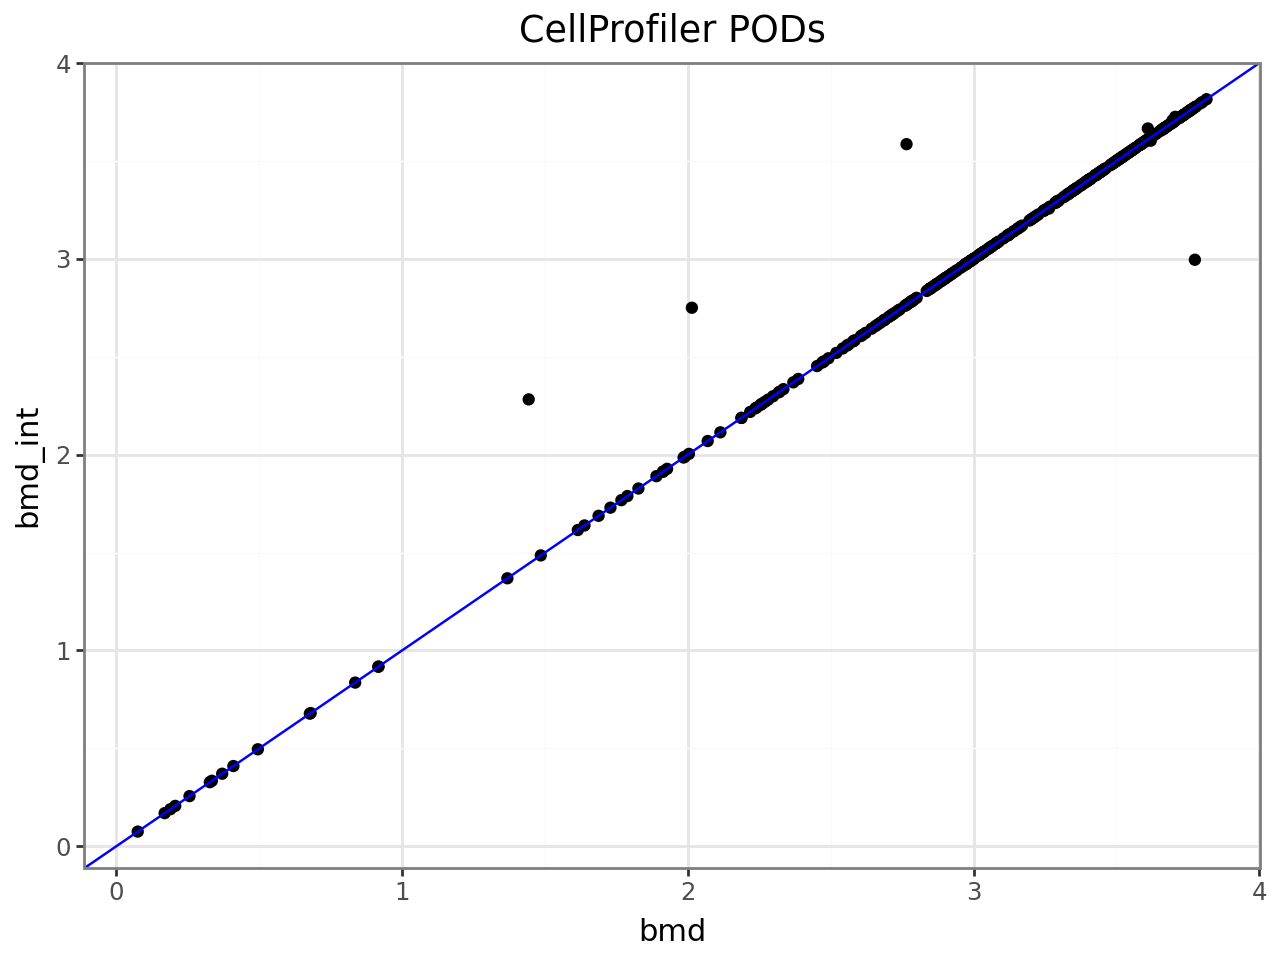

In [44]:
from plotnine import ggplot, aes, theme_bw, geom_point, labs, geom_abline

plot = (
    ggplot(cellprofiler_gmd, aes(x='bmd', y='bmd_int')) 
    + geom_point() 
    + geom_abline(intercept=0, slope=1, color="blue")
    + labs(title='CellProfiler PODs') 
    + theme_bw()
)
plot.show()

/dgx1nas1/storage/data/jess/miniforge3/envs/axiom/lib/python3.9/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 207 rows containing missing values.


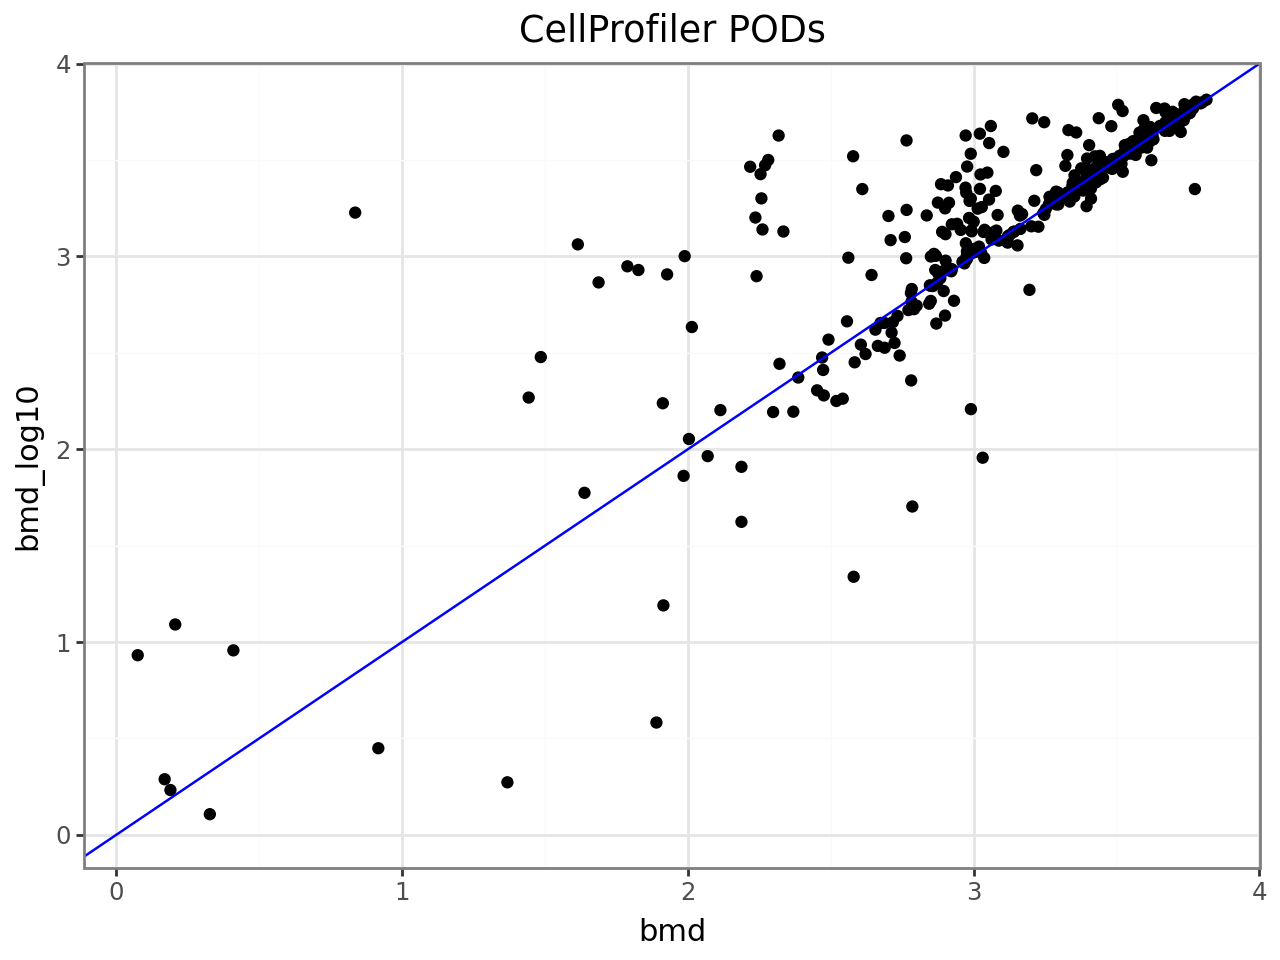

In [45]:
from plotnine import ggplot, aes, theme_bw, geom_point, labs, geom_abline

plot = (
    ggplot(cellprofiler_gmd, aes(x='bmd', y='bmd_log10')) 
    + geom_point() 
    + geom_abline(intercept=0, slope=1, color="blue")
    + labs(title='CellProfiler PODs') 
    + theme_bw()
)
plot.show()

/dgx1nas1/storage/data/jess/miniforge3/envs/axiom/lib/python3.9/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 301 rows containing missing values.


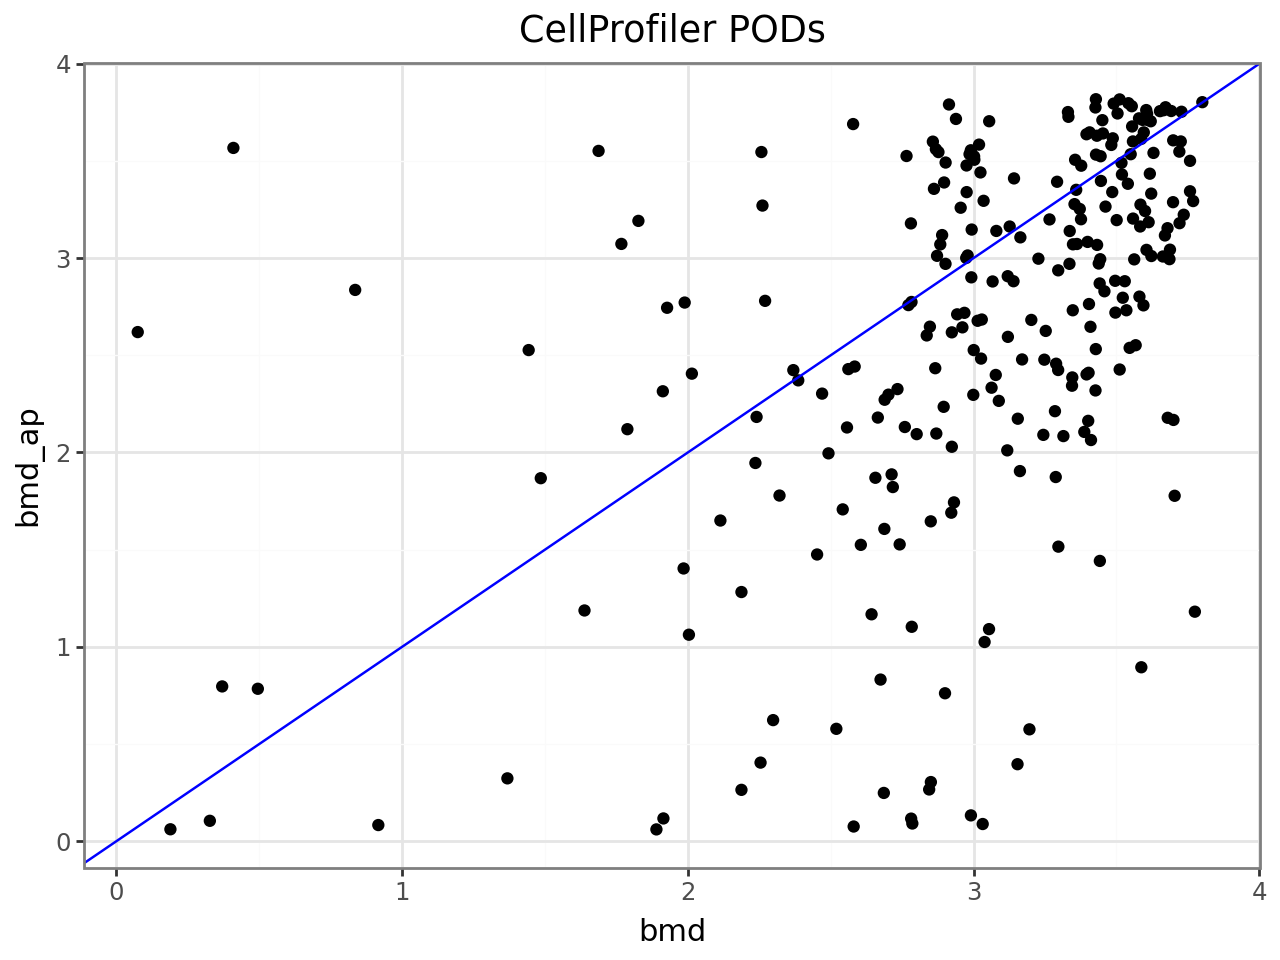

In [46]:
from plotnine import ggplot, aes, theme_bw, geom_point, labs, geom_abline

plot = (
    ggplot(cellprofiler_gmd, aes(x='bmd', y='bmd_ap')) 
    + geom_point() 
    + geom_abline(intercept=0, slope=1, color="blue")
    + labs(title='CellProfiler PODs') 
    + theme_bw()
)
plot.show()

## CP-CNN plots

/dgx1nas1/storage/data/jess/miniforge3/envs/axiom/lib/python3.9/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 92 rows containing missing values.


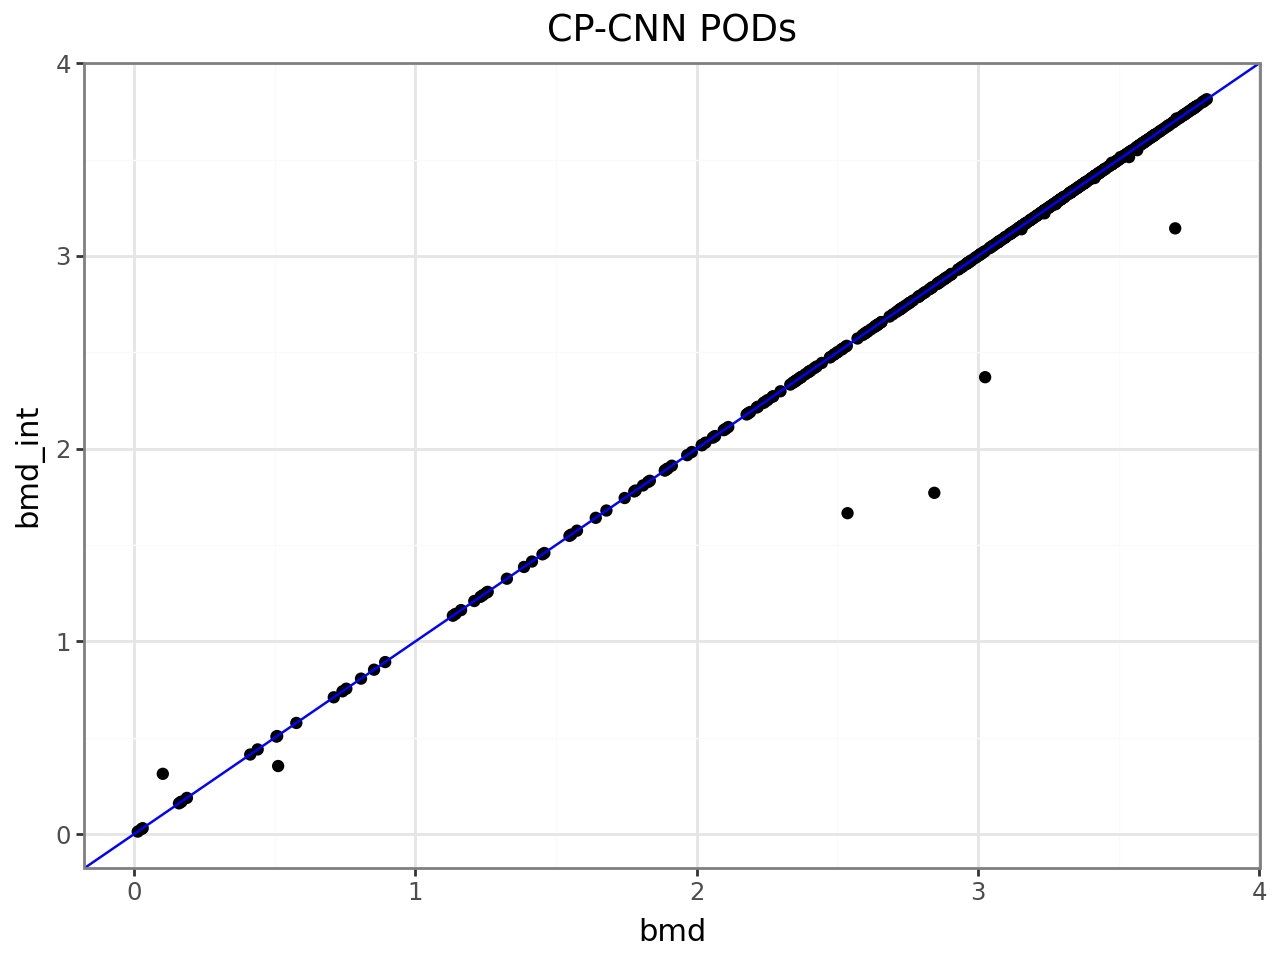

In [27]:
from plotnine import ggplot, aes, theme_bw, geom_point, labs, geom_abline

plot = (
    ggplot(cpcnn_pods, aes(x='bmd', y='bmd_int')) 
    + geom_point() 
    + geom_abline(intercept=0, slope=1, color="blue")
    + labs(title='CP-CNN PODs') 
    + theme_bw()
)
plot.show()

/dgx1nas1/storage/data/jess/miniforge3/envs/axiom/lib/python3.9/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 119 rows containing missing values.


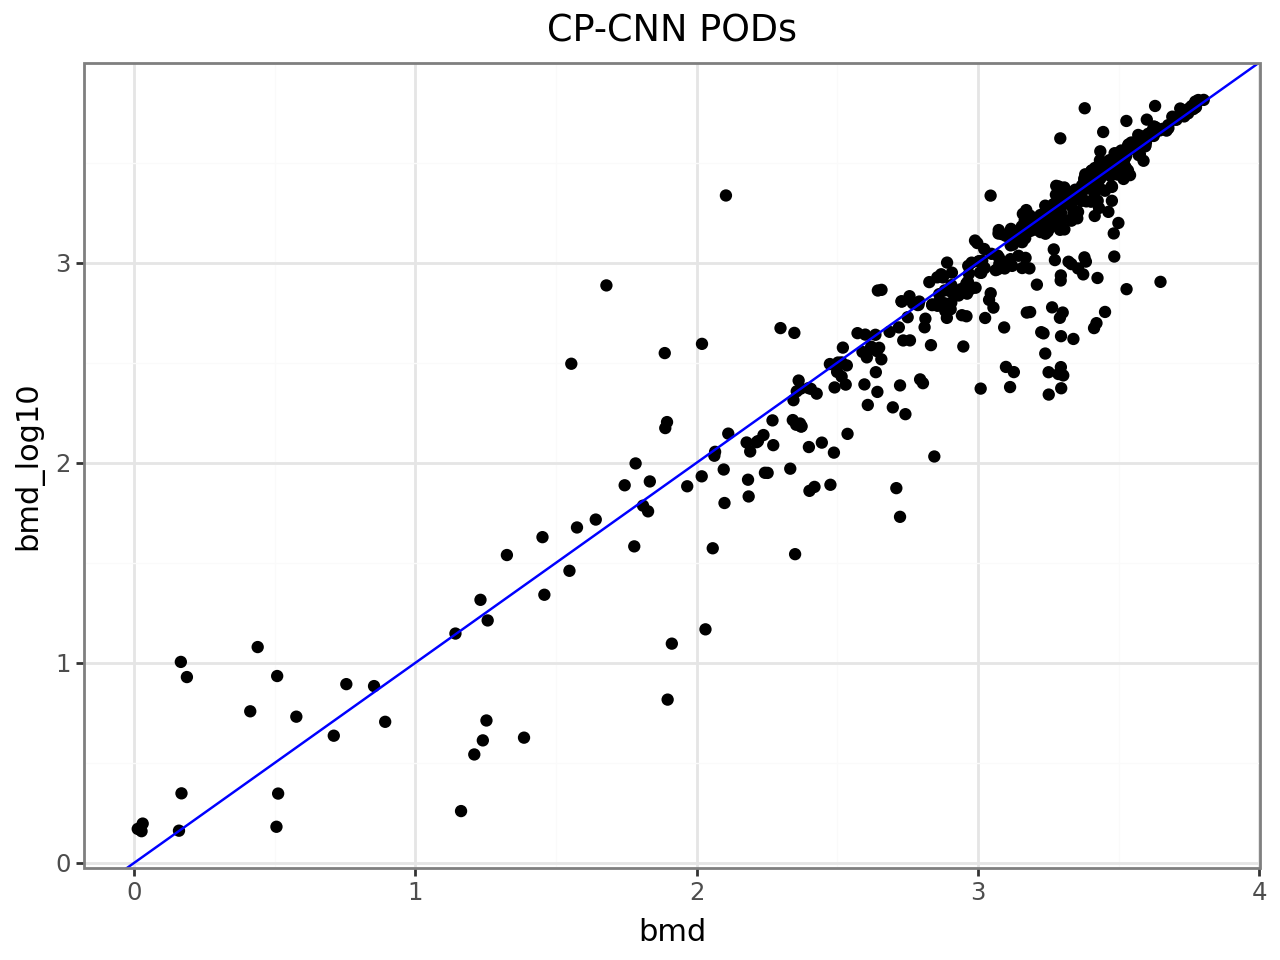

In [28]:
from plotnine import ggplot, aes, theme_bw, geom_point, labs, geom_abline

plot = (
    ggplot(cpcnn_pods, aes(x='bmd', y='bmd_log10')) 
    + geom_point() 
    + geom_abline(intercept=0, slope=1, color="blue")
    + labs(title='CP-CNN PODs') 
    + theme_bw()
)
plot.show()

/dgx1nas1/storage/data/jess/miniforge3/envs/axiom/lib/python3.9/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 252 rows containing missing values.


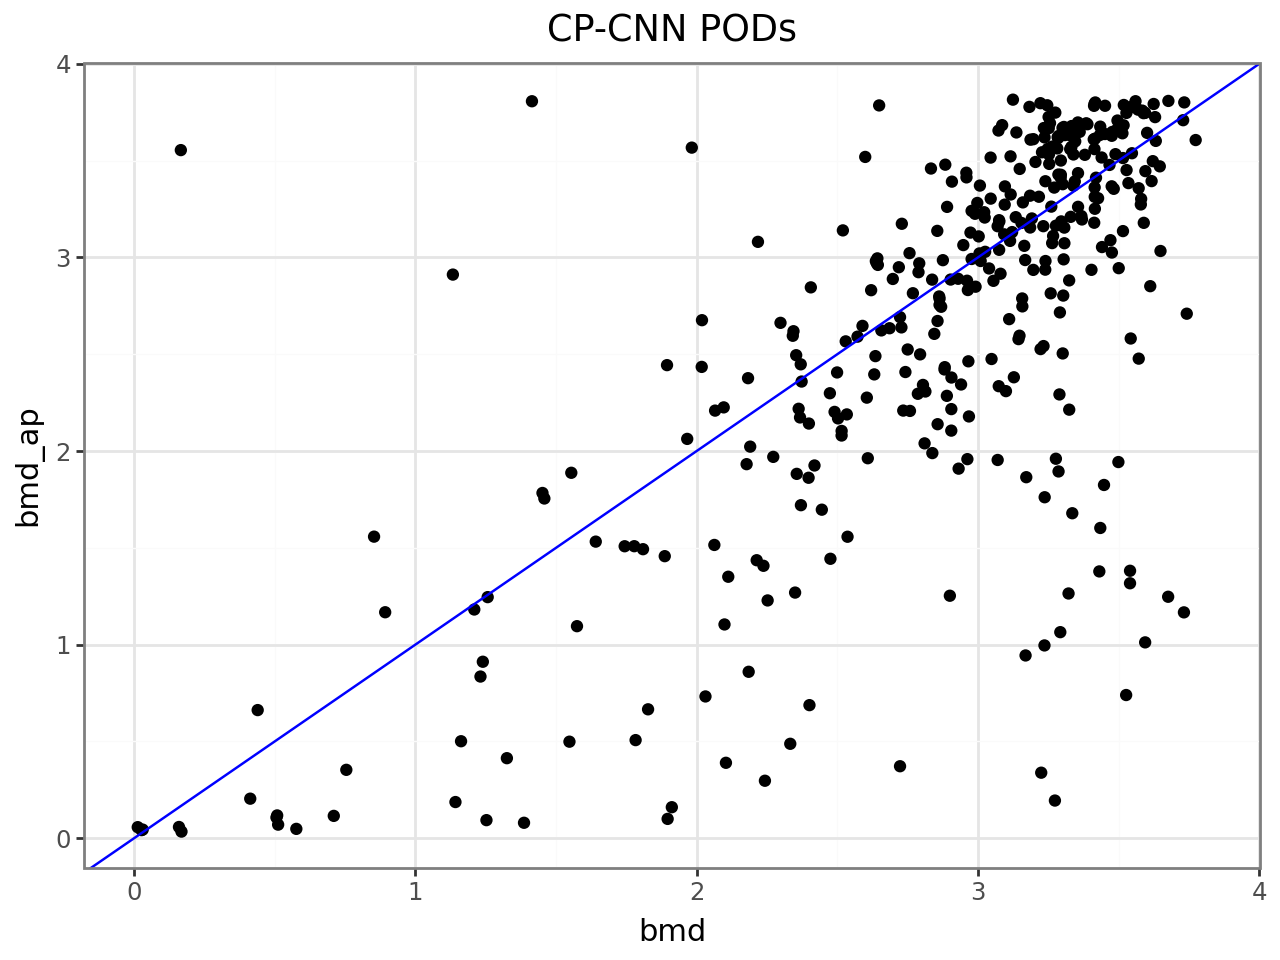

In [29]:
from plotnine import ggplot, aes, theme_bw, geom_point, labs, geom_abline

plot = (
    ggplot(cpcnn_pods, aes(x='bmd', y='bmd_ap')) 
    + geom_point() 
    + geom_abline(intercept=0, slope=1, color="blue")
    + labs(title='CP-CNN PODs') 
    + theme_bw()
)
plot.show()

## DINO plots

/dgx1nas1/storage/data/jess/miniforge3/envs/axiom/lib/python3.9/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 77 rows containing missing values.


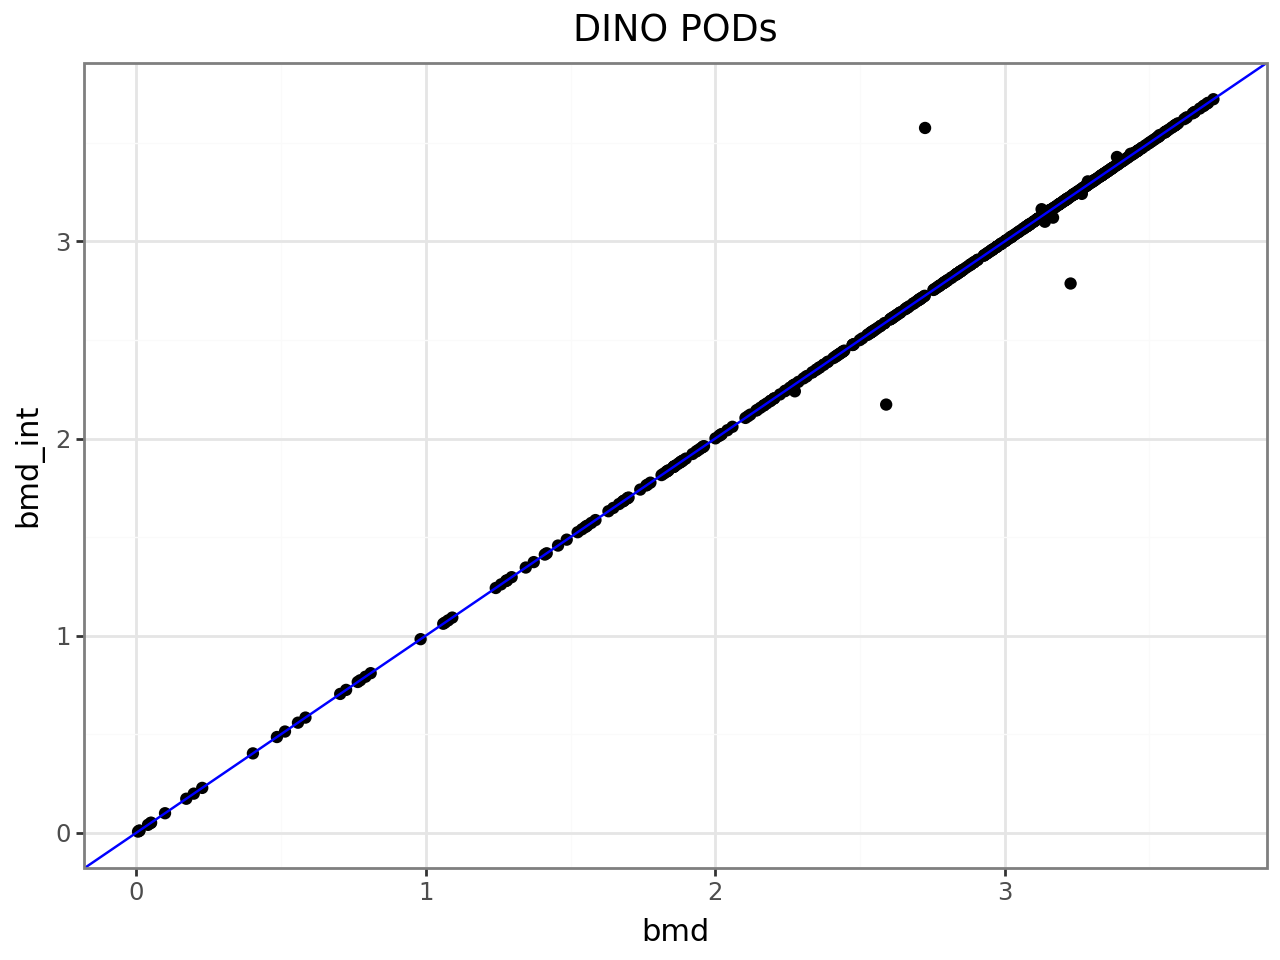

In [24]:
from plotnine import ggplot, aes, theme_bw, geom_point, labs, geom_abline

plot = (
    ggplot(dino_gmd, aes(x='bmd', y='bmd_int')) 
    + geom_point() 
    + geom_abline(intercept=0, slope=1, color="blue")
    + labs(title='DINO PODs') 
    + theme_bw()
)
plot.show()

/dgx1nas1/storage/data/jess/miniforge3/envs/axiom/lib/python3.9/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 88 rows containing missing values.


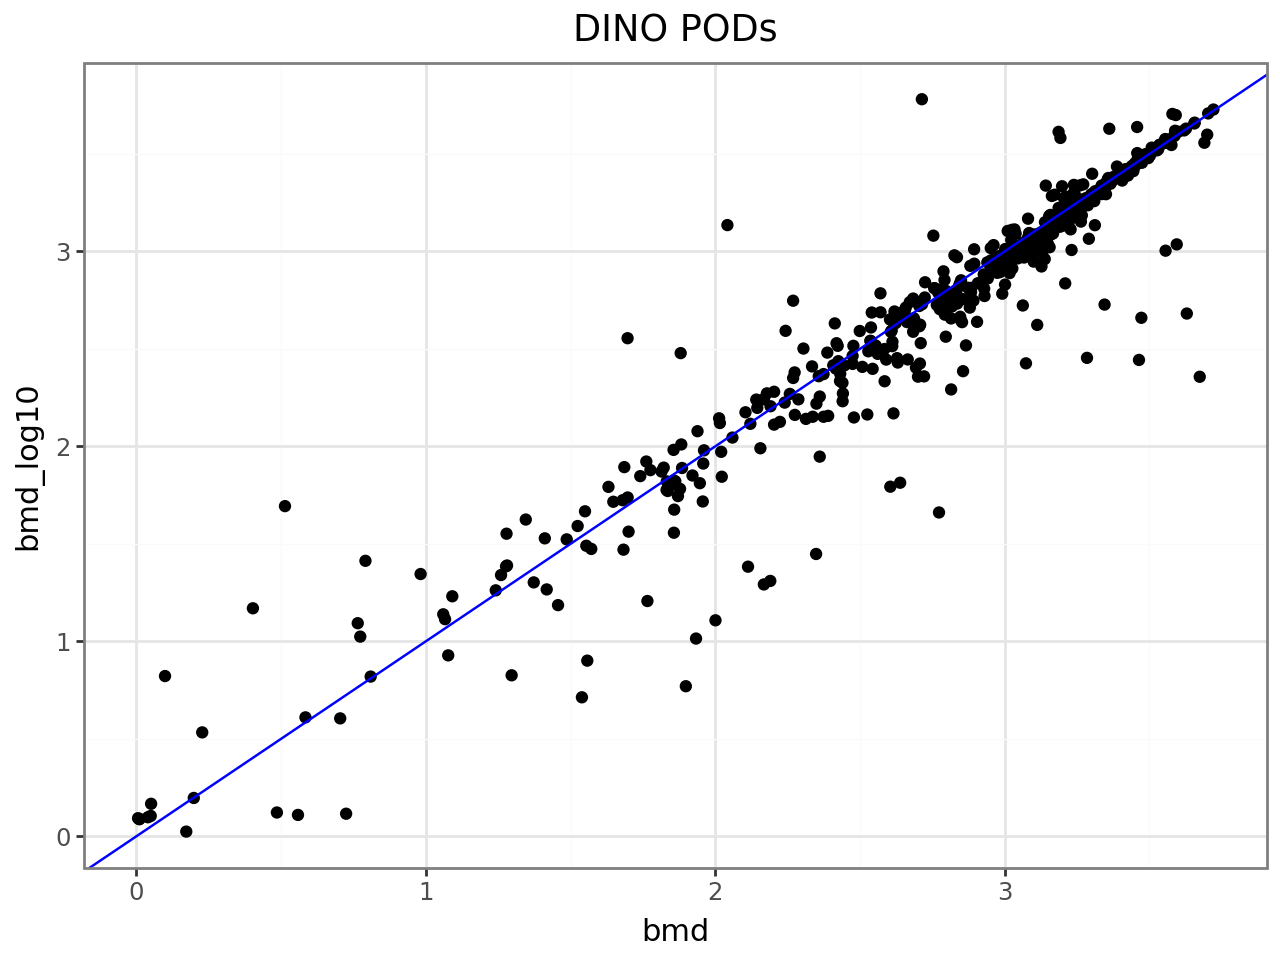

In [25]:
from plotnine import ggplot, aes, theme_bw, geom_point, labs, geom_abline

plot = (
    ggplot(dino_gmd, aes(x='bmd', y='bmd_log10')) 
    + geom_point() 
    + geom_abline(intercept=0, slope=1, color="blue")
    + labs(title='DINO PODs') 
    + theme_bw()
)
plot.show()

/dgx1nas1/storage/data/jess/miniforge3/envs/axiom/lib/python3.9/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 207 rows containing missing values.


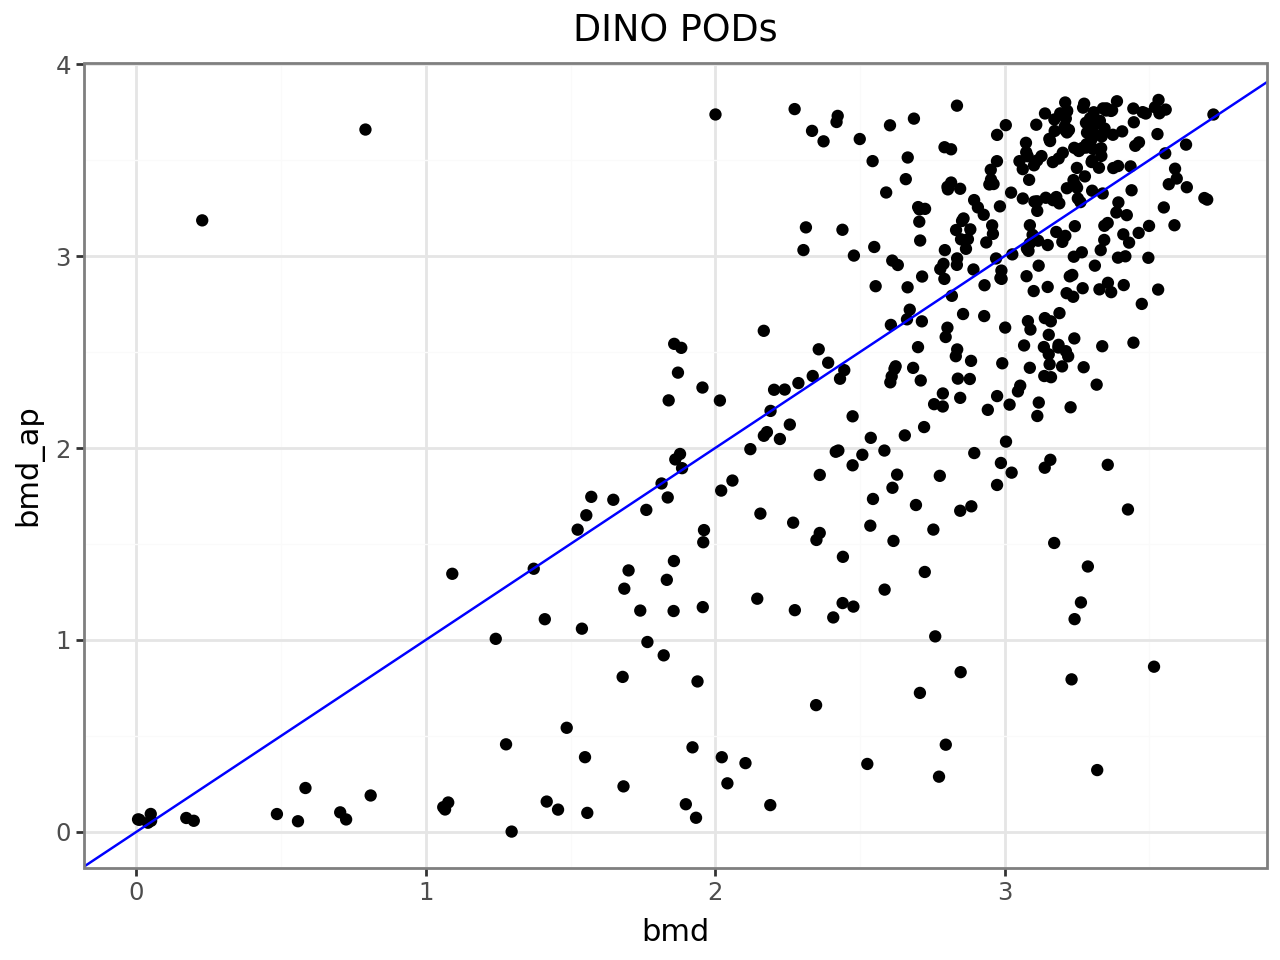

In [26]:
from plotnine import ggplot, aes, theme_bw, geom_point, labs, geom_abline

plot = (
    ggplot(dino_gmd, aes(x='bmd', y='bmd_ap')) 
    + geom_point() 
    + geom_abline(intercept=0, slope=1, color="blue")
    + labs(title='DINO PODs') 
    + theme_bw()
)
plot.show()

## Compare across represenations

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt

In [48]:
cpcnn_long = cpcnn_gmd.unpivot(
    index=["Metadata_Compound", "Feature"]
)
cellprofiler_long = cellprofiler_gmd.unpivot(
    index=["Metadata_Compound", "Feature"]
)
dino_long = dino_gmd.unpivot(
    index=["Metadata_Compound", "Feature"]
)

all_long = pl.concat([cpcnn_long, cellprofiler_long, dino_long])

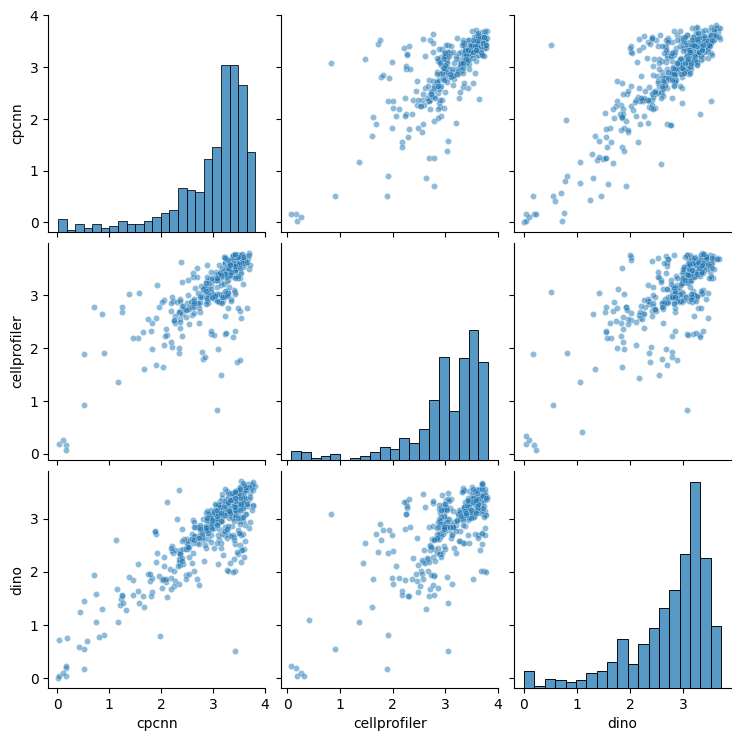

In [75]:
comp_bmd = all_long.filter(pl.col("variable") == "bmd").pivot(
    on="Feature",
    index="Metadata_Compound",
    values="value"
)

g = sns.pairplot(comp_bmd.to_pandas(), plot_kws={"alpha": 0.5, "s": 20} )
plt.show()

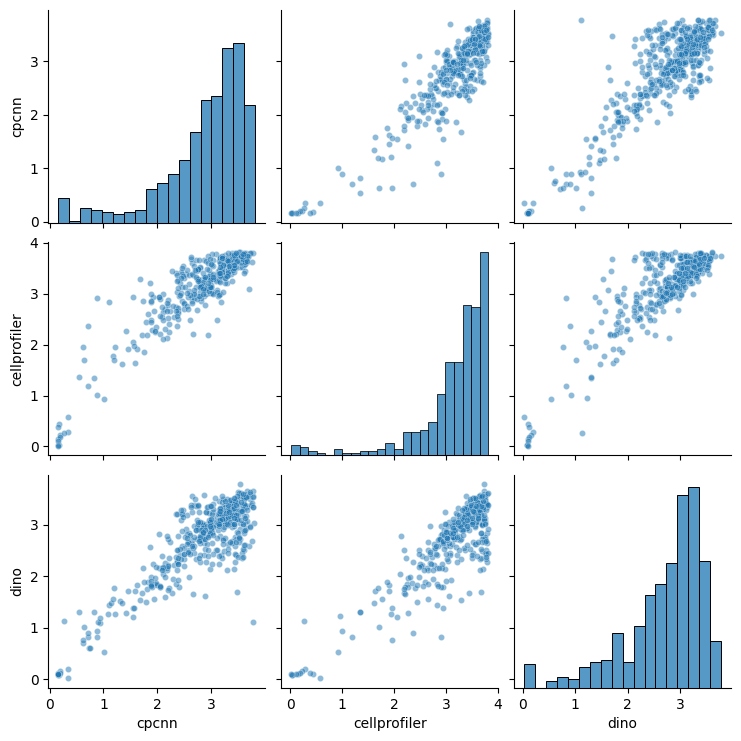

In [77]:
comp_bmd = all_long.filter(pl.col("variable") == "bmd_log10").pivot(
    on="Feature",
    index="Metadata_Compound",
    values="value"
)

g = sns.pairplot(comp_bmd.to_pandas(), plot_kws={"alpha": 0.5, "s": 20} )
plt.show()

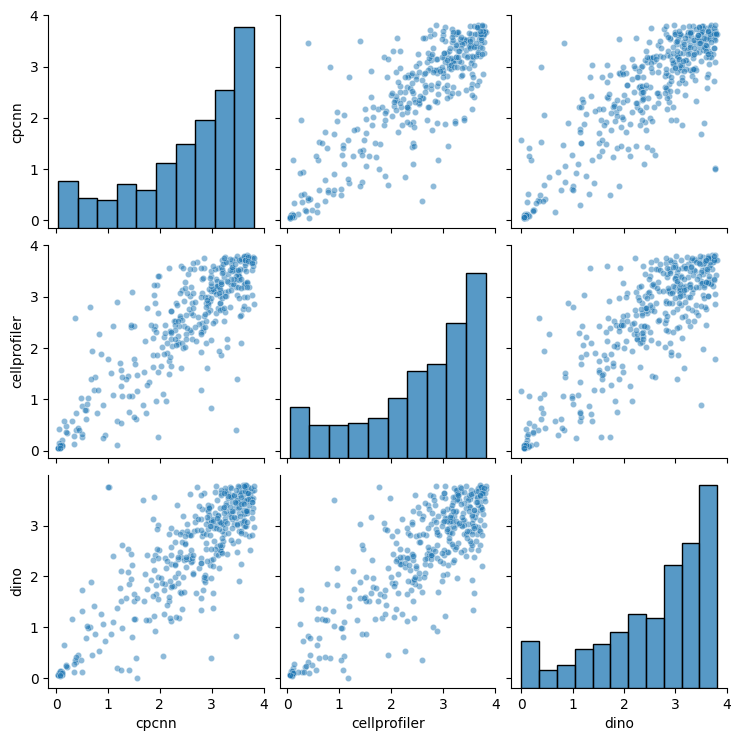

In [78]:
comp_bmd = all_long.filter(pl.col("variable") == "bmd_ap").pivot(
    on="Feature",
    index="Metadata_Compound",
    values="value"
)

g = sns.pairplot(comp_bmd.to_pandas(), plot_kws={"alpha": 0.5, "s": 20} )
plt.show()